In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=969ab9195d793bac7b11170defb393a0086635b76cea7fc9672b9a2e14dae035
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [ ]:
def fen_to_yolo_labels(fen, image_size=416):
    board = chess.Board(fen)
    square_size = image_size // 8
    labels = []

    for square, piece in board.piece_map().items():
      row, col = divmod(square, 8)
      center_x = (col + 0.5) * square_size
      center_y = (7 - row + 0.5) * square_size

      width = height = square_size

      piece_class = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5}[piece.symbol().lower()]

      if piece.symbol().isupper():
          piece_class += 6

      center_x_norm = center_x / image_size
      center_y_norm = center_y / image_size
      width_norm = width / image_size
      height_norm = height / image_size

      labels.append(f"{piece_class} {center_x_norm:.6f} {center_y_norm:.6f} {width_norm:.6f} {height_norm:.6f}")
    return labels


def save_yolo_labels(fen, idx, output_dir, image_size=416):
    labels = fen_to_yolo_labels(fen.strip(), image_size)
    with open(os.path.join(output_dir, f"board_{idx}.txt"), 'w') as label_file:
        label_file.write('\n'.join(labels))

In [ ]:
from PIL import Image
import chess
import os

# Mapping standard chess piece notation to custom filenames
PIECE_FILENAMES = {
    "P": "wp", "N": "wn", "B": "wb", "R": "wr", "Q": "wq", "K": "wk",  # White pieces
    "p": "bp", "n": "bn", "b": "bb", "r": "br", "q": "bq", "k": "bk"   # Black pieces
}

def overlay_custom_pieces(board_image, fen, piece_set_path, output_path):
    board = chess.Board(fen)
    piece_images = {key: Image.open(os.path.join(piece_set_path, f"{value}.png")).convert("RGBA")
                    for key, value in PIECE_FILENAMES.items()}

    # Board square dimensions
    square_size = board_image.width // 8

    for square, piece in board.piece_map().items():
        row, col = divmod(square, 8)
        piece_img = piece_images[piece.symbol()]
        piece_img = piece_img.resize((square_size, square_size), Image.Resampling.LANCZOS)

        # Paste the piece with transparency handling
        board_image.paste(piece_img, (col * square_size, (7 - row) * square_size), piece_img)

    board_image.save(output_path)

def generate_boards_with_custom_background(folder_path, output_board_dir,output_labels_directory, piece_set_path, board_image_path):
    os.makedirs(output_board_dir, exist_ok=True)
    count = 0

    # Load the custom board background
    base_board_image = Image.open(board_image_path).convert("RGBA")
    base_board_image = base_board_image.resize((416, 416), Image.Resampling.LANCZOS)

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            fen_file_path = os.path.join(folder_path, filename)

            with open(fen_file_path, 'r') as file:
                fens = [line.strip() for line in file if line.strip()]

                for fen in fens:
                    count += 1
                    try:
                        # Create a copy of the base board image for each FEN
                        board_image = base_board_image.copy()

                        output_path = os.path.join(output_board_dir, f"board_{count}.png")

                        overlay_custom_pieces(board_image, fen, piece_set_path, output_path)
                        save_yolo_labels(fen, count, output_labels_directory)

                        print(f"Saved board image: {output_path}")
                    except Exception as e:
                        print(f"Error processing FEN at line {count}: {e}")

fen_path = "/content/test_dir"     # Replace with the path to your FEN files
output_board_directory = "/content/output"  # Replace with the path to save the generated board images
output_labels_directory = "/content/labels" # Replace with the path to save the YOLO labels   
piece_set_directory = "/content/image"      # Replace with the path to your custom piece images
board_image_path = "/content/board.png"  # Path to your custom board image

generate_boards_with_custom_background(folder_path, output_board_directory, output_labels_directory, piece_set_directory, board_image_path)

Saved board image: /content/output/board_1.png


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def drawBoxes(image_path, boxes_path):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape  # Get image dimensions

    with open(boxes_path, 'r') as file:
        boxes = file.readlines()

    for box_data in boxes:
        class_id, x_center, y_center, width, height = box_data.split()

        # Convert to float and scale to image dimensions
        x_center = float(x_center) * image_width
        y_center = float(y_center) * image_height
        width = float(width) * image_width
        height = float(height) * image_height

        # Calculate top-left corner coordinates
        x_min = int(x_center - (width / 2))
        y_min = int(y_center - (height / 2))
        x_max = int(x_center + (width / 2))
        y_max = int(y_center + (height / 2))


        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cv2_imshow(image)

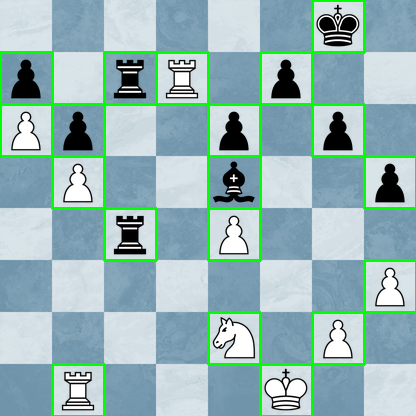

In [ ]:
drawBoxes('/content/output/board_1.png', '/content/labels/image_1.txt')

In [ ]:
import os
import shutil
import random

def get_files_in_dir(directory, extensions):
    """
    Retrieve all files in a directory with the specified extensions.
    """
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(extensions):
                files.append(os.path.join(root, filename))
    return files


def split_dataset(image_dir, label_dir, output_dir, split_ratio=0.8):
    """
    Split the dataset into training and validation sets,
    copying images and labels into YOLO-compatible folder structures.
    """
    # Retrieve images and labels
    image_files = sorted(get_files_in_dir(image_dir, ('.png', '.jpg', '.jpeg')))
    label_files = sorted(get_files_in_dir(label_dir, ('.txt',)))

    print(f"Number of image files: {len(image_files)}")
    print(f"Number of label files: {len(label_files)}")

    # Ensure images and labels match
    if len(image_files) != len(label_files):
        raise ValueError("Number of image files and label files do not match")

    # Pair images and labels by filename without extensions
    image_basenames = [os.path.splitext(os.path.basename(img))[0] for img in image_files]
    label_basenames = [os.path.splitext(os.path.basename(lbl))[0] for lbl in label_files]

    if set(image_basenames) != set(label_basenames):
        raise ValueError("Image and label filenames do not match")

    # Pair and shuffle
    combined = list(zip(image_files, label_files))
    random.shuffle(combined)
    image_files, label_files = zip(*combined)

    # Calculate split index
    split_index = int(len(image_files) * split_ratio)
    train_images, val_images = image_files[:split_index], image_files[split_index:]
    train_labels, val_labels = label_files[:split_index], label_files[split_index:]

    # Define output directories
    dirs = {
        'train_images': os.path.join(output_dir, 'train', 'images'),
        'train_labels': os.path.join(output_dir, 'train', 'labels'),
        'val_images': os.path.join(output_dir, 'val', 'images'),
        'val_labels': os.path.join(output_dir, 'val', 'labels')
    }

    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    # Copy training files
    for img, lbl in zip(train_images, train_labels):
        shutil.copy(img, os.path.join(dirs['train_images'], os.path.basename(img)))
        shutil.copy(lbl, os.path.join(dirs['train_labels'], os.path.basename(lbl)))

    # Copy validation files
    for img, lbl in zip(val_images, val_labels):
        shutil.copy(img, os.path.join(dirs['val_images'], os.path.basename(img)))
        shutil.copy(lbl, os.path.join(dirs['val_labels'], os.path.basename(lbl)))

    print(f"✅ Dataset split completed successfully!")
    print(f"🔹 Training set: {len(train_images)} images, {len(train_labels)} labels")
    print(f"🔹 Validation set: {len(val_images)} images, {len(val_labels)} labels")


# Example usage
if __name__ == "__main__":
    image_dir = r"/content/images"
    label_dir = r"/content/labels"
    output_dir = r"/content/dataset"
    split_dataset(image_dir, label_dir, output_dir)
